This shows a workthrough using cvxopt to perform a Lasso. cvxopt is very nice because it allows you to wrap in inequalities or constraints into your optimization. Say you have a system of linear equations 
\begin{align}
\mathbf{A\cdot x = y}.
\end{align}
$\mathbf{A}$ is an $m\times n$ matrix of independant variables, $\mathbf{y}$ is a vector of dependent measurements. You want to fit $\mathbf{x}$, but you want to avoid overfitting too many parameters. In such a scenario, you might minimize the objective function 
\begin{align}
O = \frac{1}{2m}\left ( \mathbf{A\cdot x - y} \right)^T \cdot \left ( \mathbf{A\cdot x - y} \right) - \lambda \sum_i^n |x_i|
\end{align}
The left term is a typical sum of squares objective function, the right term is called a Lasso penalty, with the strength of the penalty determined by $\lambda$. This problem is minimized by Python's sklearn.linear_model Lasso packages. I usually use cross-validation to learn the lasso penalty, but for this exercise I just want to see if the algorithm works. Let's make a toy underdetermined data set with more parameters than samples. Only 10 of the parameters will actually be predictive. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path, Lasso
import pylab

pylab.rcParams['font.size'] = 18

def lasso_scan(A,y, num_penalties=100, log_penalty_range=6):
    m = A.shape[0] 
    max_penalty = np.max(np.abs(- A.T.dot(y) / m)) # lambda should never be higher than this boundary
    max_penalty *= 10 # optional line, pads a little so that we can see changes in the Lasso stop affecting the model
    penalties = np.logspace(np.log10(max_penalty), 
                            np.log10(max_penalty)-log_penalty_range, 
                            num_penalties)#penalties to scan
    
    _ , coef_path, _ = lasso_path(A, y, alphas=penalties)
    
    return penalties, coef_path

np.random.seed(0)
m=100
n=500
A = np.random.randn(m,n)
x_true = np.random.randn(n)
x_true[10:] = 0
y = A.dot(x_true) + np.random.randn(m)*3



And now let's scan it using sklearn lasso library as a control:

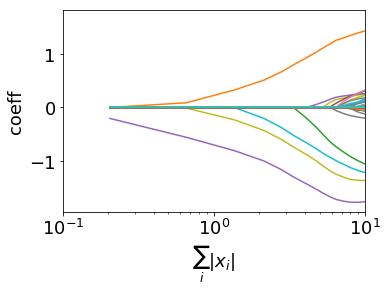

In [2]:
penalties, coeffs = lasso_scan(A,y)
fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.semilogx(np.sum(np.abs(coeffs.T), axis=1), coeffs.T)
ax.set_xlabel(r'$\sum_i |x_i|$')
ax.set_ylabel('coeff')
ax.set_xlim([1e-1,10])
plt.show()
plt.close()

OK, next, we want to try using cvxopt to analyze this. Let's see if it's up the challenge!

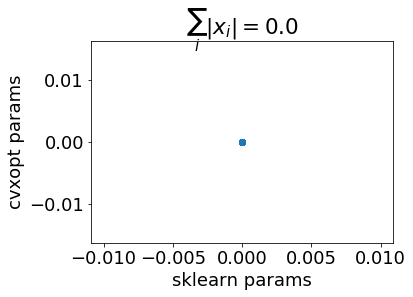

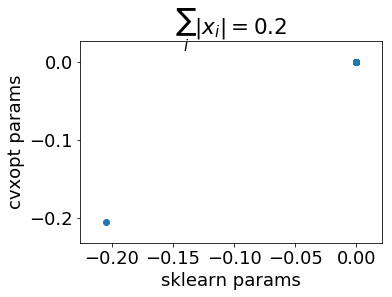

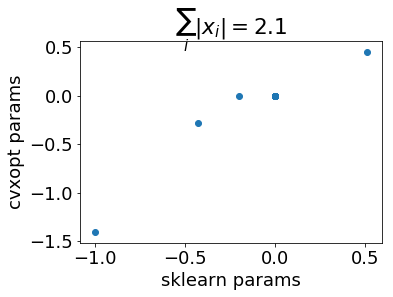

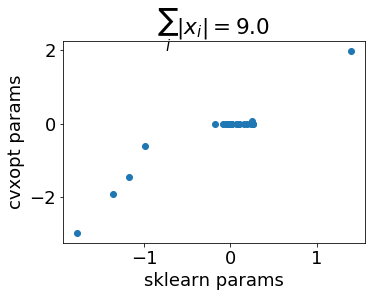

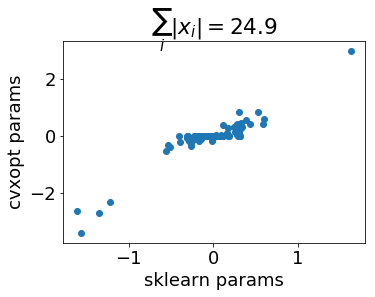

In [3]:
from cvxopt_lasso import monotonic_lasso
for ind in [10, 17, 20, 30, 80]:
    cvxopt_params = monotonic_lasso(A, y, np.sum(np.abs(coeffs[:, ind])))
    fig = plt.figure()
    ax = fig.add_axes([0.2,0.2,0.7,0.7])
    ax.scatter(coeffs[:,ind], cvxopt_params)
    ax.set_xlabel(r'sklearn params')
    ax.set_ylabel('cvxopt params')
    ax.set_title(r'$\sum_i |x_i|=%.1f$'%np.sum(np.abs(coeffs[:, ind])))
    plt.show()
    plt.close()


OK, so these two methods are kind of close, but they're not identical. Let's find out which one is closer to being true.

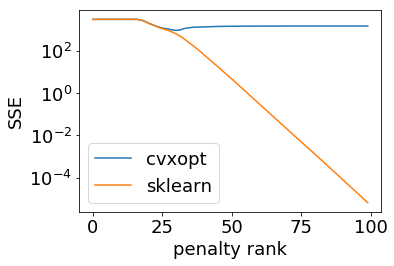

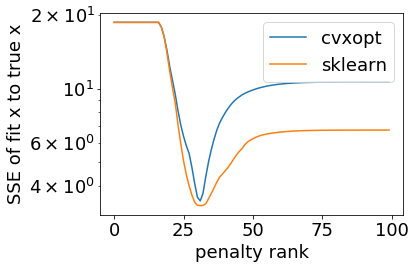

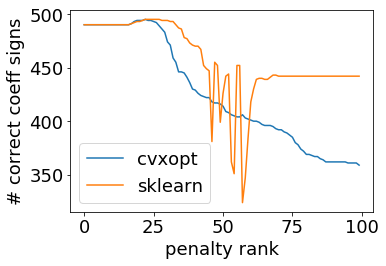

In [4]:
sklearn_SSE = []
cvxopt_SSE = []
sklearn_true_SSE = []
cvxopt_true_SSE = []
sklearn_correct_sign = []
cvxopt_correct_sign = []


for ind in range(coeffs.shape[1]):
    cvxopt_params = monotonic_lasso(A, y, np.sum(np.abs(coeffs[:, ind])))
    cvxopt_params[np.abs(cvxopt_params) < 1e-7] = 0 #cvxopt tends to have a lot numerical noise, so insist small numbers are 0
    sklearn_SSE.append(np.sum((y - A.dot(coeffs[:, ind].flatten()))**2))
    cvxopt_SSE.append(np.sum((y - A.dot(cvxopt_params.flatten()))**2))
    cvxopt_params[np.abs(cvxopt_params) < 1e-7] = 0 #cvxopt tends to have a lot numerical noise, so insist small numbers are 0
    sklearn_true_SSE.append(np.sum((x_true.flatten() - coeffs[:, ind].flatten())**2))
    cvxopt_true_SSE.append(np.sum((x_true.flatten() - cvxopt_params.flatten())**2))
    sklearn_correct_sign.append(np.sum(np.sign(x_true) == np.sign(coeffs[:, ind].flatten())))
    cvxopt_correct_sign.append(np.sum(np.sign(x_true) == np.sign(cvxopt_params.flatten())))

fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.semilogy(cvxopt_SSE, label='cvxopt')
ax.semilogy(sklearn_SSE, label='sklearn')
plt.legend()
ax.set_xlabel(r'penalty rank')
ax.set_ylabel('SSE')
plt.show()
plt.close()


fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.semilogy(cvxopt_true_SSE, label='cvxopt')
ax.semilogy(sklearn_true_SSE, label='sklearn')
plt.legend()
ax.set_xlabel(r'penalty rank')
ax.set_ylabel('SSE of fit x to true x')
plt.show()
plt.close()


fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.plot(sklearn_correct_sign, label='cvxopt')
ax.plot(cvxopt_correct_sign, label='sklearn')
plt.legend()
ax.set_xlabel(r'penalty rank')
ax.set_ylabel('# correct coeff signs')
plt.show()
plt.close()

These results suggests that cvxopt is giving equivalently good answers to sklearn for large penalties, but is breaking down when there are more parameters than data points. Let's go ahead and verify this, and not worry too much about the degenerate cases of lasso:

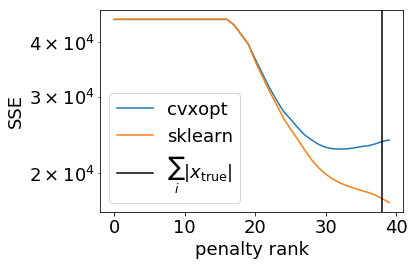

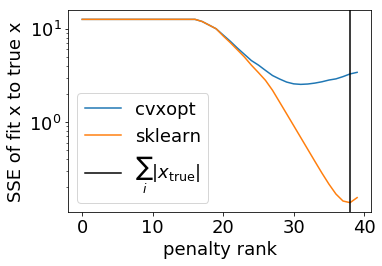

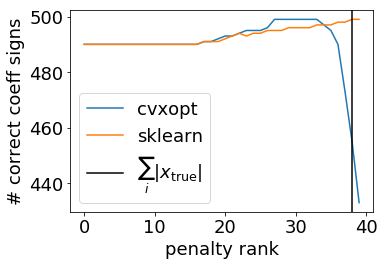

In [ ]:
np.random.seed(0)

m=2000
n=500
A = np.random.randn(m,n)
x_true = np.random.randn(n)
x_true[10:] = 0
y = A.dot(x_true) + np.random.randn(m)*3
penalties, coeffs = lasso_scan(A,y)


sklearn_SSE = []
cvxopt_SSE = []
sklearn_true_SSE = []
cvxopt_true_SSE = []
sklearn_correct_sign = []
cvxopt_correct_sign = []
exceeded_original = []

#coeffs.shape[1]
for ind in range(0,40):
    exceeded_original.append(np.sum(np.abs(coeffs[:, ind])) > np.sum(np.abs(x_true)))
    cvxopt_params = monotonic_lasso(A, y, np.sum(np.abs(coeffs[:, ind])))
    sklearn_SSE.append(np.sum((y - A.dot(coeffs[:, ind].flatten()))**2))
    cvxopt_SSE.append(np.sum((y - A.dot(cvxopt_params.flatten()))**2))
    cvxopt_params[np.abs(cvxopt_params) < 1e-7] = 0 #cvxopt tends to have a lot numerical noise, so insist small numbers are 0
    sklearn_true_SSE.append(np.sum((x_true.flatten() - coeffs[:, ind].flatten())**2))
    cvxopt_true_SSE.append(np.sum((x_true.flatten() - cvxopt_params.flatten())**2))
    sklearn_correct_sign.append(np.sum(np.sign(x_true) == np.sign(coeffs[:, ind].flatten())))
    cvxopt_correct_sign.append(np.sum(np.sign(x_true) == np.sign(cvxopt_params.flatten())))

exceed_point = np.where(exceeded_original)[0][0]
fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.semilogy(cvxopt_SSE, label='cvxopt')
ax.semilogy(sklearn_SSE, label='sklearn')
ax.axvline(exceed_point,c=(0,0,0), label=r'$\sum_i |x_{\rm{true}}|$')
plt.legend()
ax.set_xlabel(r'penalty rank')
ax.set_ylabel('SSE')
plt.show()
plt.close()


fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.semilogy(cvxopt_true_SSE, label='cvxopt')
ax.semilogy(sklearn_true_SSE, label='sklearn')
ax.axvline(exceed_point,c=(0,0,0), label=r'$\sum_i |x_{\rm{true}}|$')


plt.legend()
ax.set_xlabel(r'penalty rank')
ax.set_ylabel('SSE of fit x to true x')
plt.show()
plt.close()


fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.plot(sklearn_correct_sign, label='cvxopt')
ax.plot(cvxopt_correct_sign, label='sklearn')
ax.axvline(exceed_point,c=(0,0,0), label=r'$\sum_i |x_{\rm{true}}|$')
plt.legend()
ax.set_xlabel(r'penalty rank')
ax.set_ylabel('# correct coeff signs')
plt.show()
plt.close()

Alright, well it seems that cvxopt performs reasonably well up to the sum of the absolute values of the true x, but does break down. It may also be getting the sign of the parameters better, but that is a question for another day. This seems like an important caveat for this method. Perhaps with a better engine, this would stop happening. Anyways, although cvxopt might seem like the inferior method, beyond this point it can really shine. Say you want to drop the lasso penalty for some of your parameters that you know are relevant. cvxopt can handle this just fine. Let's allow the algorithm to go ahead and fit the first 5 parameters

In [ ]:
sklearn_SSE = []
cvxopt_SSE = []
sklearn_true_SSE = []
cvxopt_true_SSE = []
sklearn_correct_sign = []
cvxopt_correct_sign = []
exceeded_original = []

#coeffs.shape[1]
for ind in range(0,40):
    exceeded_original.append(np.sum(np.abs(coeffs[:, ind])) > np.sum(np.abs(x_true)))
    cvxopt_params = monotonic_lasso(A, y, np.sum(np.abs(coeffs[:, ind])), no_lasso=range(10))
    sklearn_SSE.append(np.sum((y - A.dot(coeffs[:, ind].flatten()))**2))
    cvxopt_SSE.append(np.sum((y - A.dot(cvxopt_params.flatten()))**2))
    cvxopt_params[np.abs(cvxopt_params) < 1e-7] = 0 #cvxopt tends to have a lot numerical noise, so insist small numbers are 0
    sklearn_true_SSE.append(np.sum((x_true.flatten() - coeffs[:, ind].flatten())**2))
    cvxopt_true_SSE.append(np.sum((x_true.flatten() - cvxopt_params.flatten())**2))
    sklearn_correct_sign.append(np.sum(np.sign(x_true) == np.sign(coeffs[:, ind].flatten())))
    cvxopt_correct_sign.append(np.sum(np.sign(x_true) == np.sign(cvxopt_params.flatten())))

exceed_point = np.where(exceeded_original)[0][0]
fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.semilogy(cvxopt_SSE, label='cvxopt')
ax.semilogy(sklearn_SSE, label='sklearn')
ax.axvline(exceed_point,c=(0,0,0), label=r'$\sum_i |x_{\rm{true}}|$')
plt.legend()
ax.set_xlabel(r'penalty rank')
ax.set_ylabel('SSE')
plt.show()
plt.close()


fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.semilogy(cvxopt_true_SSE, label='cvxopt')
ax.semilogy(sklearn_true_SSE, label='sklearn')
ax.axvline(exceed_point,c=(0,0,0), label=r'$\sum_i |x_{\rm{true}}|$')


plt.legend()
ax.set_xlabel(r'penalty rank')
ax.set_ylabel('SSE of fit x to true x')
plt.show()
plt.close()


fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.plot(sklearn_correct_sign, label='cvxopt')
ax.plot(cvxopt_correct_sign, label='sklearn')
ax.axvline(exceed_point,c=(0,0,0), label=r'$\sum_i |x_{\rm{true}}|$')
plt.legend()
ax.set_xlabel(r'penalty rank')
ax.set_ylabel('# correct coeff signs')
plt.show()
plt.close()

As well, say you know from previous experiments the order of the first 6 parameters. You could enforce this order using cvxopt:

In [ ]:
sklearn_SSE = []
cvxopt_SSE = []
sklearn_true_SSE = []
cvxopt_true_SSE = []
sklearn_correct_sign = []
cvxopt_correct_sign = []
exceeded_original = []

#coeffs.shape[1]
for ind in range(0,40):
    exceeded_original.append(np.sum(np.abs(coeffs[:, ind])) > np.sum(np.abs(x_true)))
    cvxopt_params = monotonic_lasso(A, y, np.sum(np.abs(coeffs[:, ind])), param_ranks = np.argsort(x_true[:6]))
    sklearn_SSE.append(np.sum((y - A.dot(coeffs[:, ind].flatten()))**2))
    cvxopt_SSE.append(np.sum((y - A.dot(cvxopt_params.flatten()))**2))
    cvxopt_params[np.abs(cvxopt_params) < 1e-7] = 0 #cvxopt tends to have a lot numerical noise, so insist small numbers are 0
    sklearn_true_SSE.append(np.sum((x_true.flatten() - coeffs[:, ind].flatten())**2))
    cvxopt_true_SSE.append(np.sum((x_true.flatten() - cvxopt_params.flatten())**2))
    sklearn_correct_sign.append(np.sum(np.sign(x_true) == np.sign(coeffs[:, ind].flatten())))
    cvxopt_correct_sign.append(np.sum(np.sign(x_true) == np.sign(cvxopt_params.flatten())))

exceed_point = np.where(exceeded_original)[0][0]
fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.semilogy(cvxopt_SSE, label='cvxopt')
ax.semilogy(sklearn_SSE, label='sklearn')
ax.axvline(exceed_point,c=(0,0,0), label=r'$\sum_i |x_{\rm{true}}|$')
plt.legend()
ax.set_xlabel(r'penalty rank')
ax.set_ylabel('SSE')
plt.show()
plt.close()


fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.semilogy(cvxopt_true_SSE, label='cvxopt')
ax.semilogy(sklearn_true_SSE, label='sklearn')
ax.axvline(exceed_point,c=(0,0,0), label=r'$\sum_i |x_{\rm{true}}|$')


plt.legend()
ax.set_xlabel(r'penalty rank')
ax.set_ylabel('SSE of fit x to true x')
plt.show()
plt.close()


fig = plt.figure()
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.plot(sklearn_correct_sign, label='cvxopt')
ax.plot(cvxopt_correct_sign, label='sklearn')
ax.axvline(exceed_point,c=(0,0,0), label=r'$\sum_i |x_{\rm{true}}|$')
plt.legend()
ax.set_xlabel(r'penalty rank')
ax.set_ylabel('# correct coeff signs')
plt.show()
plt.close()